In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.metrics import Recall
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
#For running this cell make sure to upload X_y_train.npy and X_y_test.npy.they are both in milestone2 folder.
X_y_train = np.load('X_y_train.npy')
X_y_test = np.load('X_y_test.npy')

print(f"The shape of the training data (X_y_train) is: {X_y_train.shape}")
print(f"The shape of the testing data (X_y_test) is: {X_y_test.shape}")


In [ ]:
X_y_train, X_y_val = train_test_split(X_y_train, test_size=0.2, random_state=42)

In [ ]:
X_train = X_y_train[:, :-1]  # Features
X_test = X_y_test[:, :-1]  # Features
X_val = X_y_val[:, :-1]  # Features

y_train = X_y_train[:, -1]  # Labels
y_test = X_y_test[:, -1]  # Labels
y_val = X_y_val[:, -1]  # Labels

In [ ]:
print(f'Average class probability in training set:   {y_train.mean():.4f}')
print(f'Average class probability in validation set: {y_val.mean():.4f}')
print(f'Average class probability in test set:       {y_test.mean():.4f}')

Average class probability in training set:   0.0069
Average class probability in validation set: 0.0069
Average class probability in test set:       0.0070


# GCN Model

Prepare data

In [ ]:

# Install the latest compatible version of PyTorch and torchtext
!pip install torch torchvision torchaudio torchtext --index-url https://download.pytorch.org/whl/cu118

# Install PyTorch Geometric and its dependencies
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
!pip install torch-spline-conv -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
!pip install torch-geometric

Looking in indexes: https://download.pytorch.org/whl/cu118
INFO: pip is looking at multiple versions of torchtext to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 30.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 36.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 37.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 27.2 MB/s eta 0:00:00
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.18.0
    Uninstalling torchtext-0.18.0:
      Successfully uninstalled torchtext-0.18.0
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
Looking in links: http

In [ ]:
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.loader import DataLoader
from sklearn.metrics import accuracy_score, recall_score
import numpy as np
import torch.nn.functional as F

# Convert numpy arrays to PyTorch tensors
x_train = torch.tensor(X_train, dtype=torch.float)
x_test = torch.tensor(X_test, dtype=torch.float)
x_val = torch.tensor(X_val, dtype=torch.float)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)
y_val = torch.tensor(y_val, dtype=torch.long)

# Create a combined dataset
x = torch.cat([x_train, x_test, x_val], dim=0)
y = torch.cat([y_train, y_test, y_val], dim=0)

# Create a smaller edge list for demonstration (KNN approach can be used here)
from sklearn.neighbors import kneighbors_graph

adj_matrix = kneighbors_graph(x, n_neighbors=5, mode='connectivity', include_self=False)
edge_index = torch.tensor(np.array(adj_matrix.nonzero()), dtype=torch.long)




<ipython-input-9-c38004d0232f>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.long)
<ipython-input-9-c38004d0232f>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.long)
<ipython-input-9-c38004d0232f>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_val = torch.tensor(y_val, dtype=torch.long)


In [ ]:
# Create masks for train, test, and validation sets
num_nodes = x.shape[0]
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask = torch.zeros(num_nodes, dtype=torch.bool)

train_mask[:len(x_train)] = True
test_mask[len(x_train):len(x_train) + len(x_test)] = True
val_mask[len(x_train) + len(x_test):] = True

# Create a PyTorch Geometric data object
data = Data(x=x, edge_index=edge_index, y=y, train_mask=train_mask, test_mask=test_mask, val_mask=val_mask)

In [ ]:
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Initialize the model, optimizer, and loss function
model = GCN(in_channels=9, hidden_channels=16, out_channels=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

# Training function
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

# Validation function
def validate():
    model.eval()
    out = model(data)
    val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
    pred = out[data.val_mask].argmax(dim=1)
    correct = pred == data.y[data.val_mask]
    acc = int(correct.sum()) / int(data.val_mask.sum())
    recall = recall_score(data.y[data.val_mask].cpu(), pred.cpu(), average='macro')
    return val_loss.item(), acc, recall

# Testing function
def test(mask):
    model.eval()
    out = model(data)
    pred = out[mask].argmax(dim=1)
    correct = pred == data.y[mask]
    acc = int(correct.sum()) / int(mask.sum())
    recall = recall_score(data.y[mask].cpu(), pred.cpu(), average='macro')
    return acc, recall


Epoch: 000, Loss: 789.5237, Val Loss: 5.2830, Val Accuracy: 0.9931, Val Recall: 0.5000
Epoch: 010, Loss: 62.3873, Val Loss: 64.7663, Val Accuracy: 0.9931, Val Recall: 0.5000
Epoch: 020, Loss: 75.5554, Val Loss: 75.4915, Val Accuracy: 0.9931, Val Recall: 0.5000
Epoch: 030, Loss: 72.6343, Val Loss: 71.6530, Val Accuracy: 0.9931, Val Recall: 0.5000
Epoch: 040, Loss: 63.2415, Val Loss: 61.9088, Val Accuracy: 0.9931, Val Recall: 0.5000
Epoch: 050, Loss: 51.0356, Val Loss: 49.5618, Val Accuracy: 0.9931, Val Recall: 0.5000
Epoch: 060, Loss: 37.2060, Val Loss: 35.6369, Val Accuracy: 0.9931, Val Recall: 0.5000
Epoch: 070, Loss: 21.6924, Val Loss: 19.9774, Val Accuracy: 0.9931, Val Recall: 0.5000
Epoch: 080, Loss: 3.4749, Val Loss: 3.9658, Val Accuracy: 0.9680, Val Recall: 0.6174
Epoch: 090, Loss: 6.4218, Val Loss: 6.1839, Val Accuracy: 0.9931, Val Recall: 0.5000
Epoch: 100, Loss: 2.7540, Val Loss: 3.3673, Val Accuracy: 0.9931, Val Recall: 0.5000
Epoch: 110, Loss: 2.6311, Val Loss: 2.6819, Val A

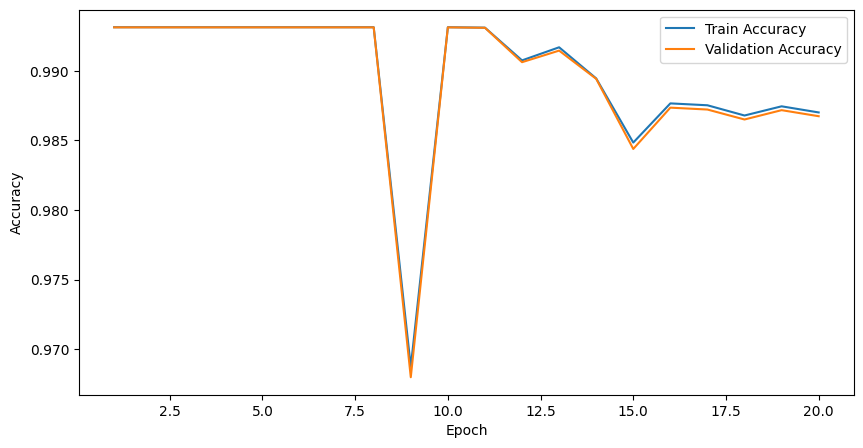

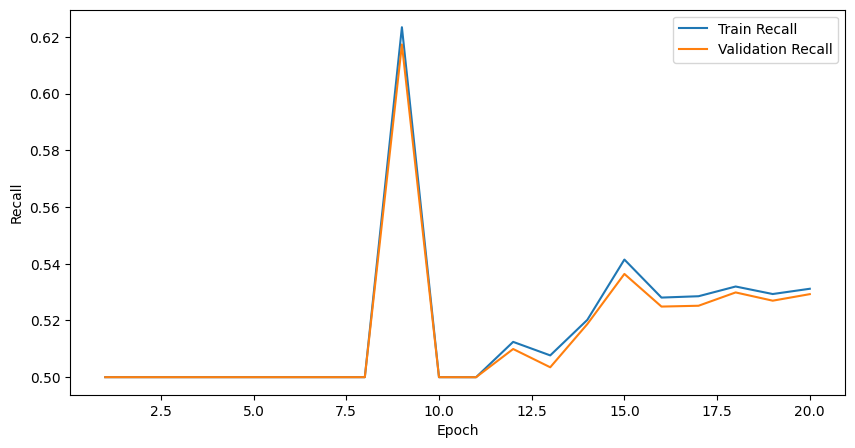

In [ ]:

# Store accuracy and recall for plotting
train_accuracies = []
val_accuracies = []
train_recalls = []
val_recalls = []

num_epochs = 200

for epoch in range(num_epochs):
    loss = train()
    val_loss, val_acc, val_recall = validate()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}, Val Recall: {val_recall:.4f}')

        train_acc, train_recall = test(data.train_mask)  # Test on the training set
        val_acc, val_recall = test(data.val_mask)  # Test on the validation set
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        train_recalls.append(train_recall)
        val_recalls.append(val_recall)

# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot recall
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_recalls) + 1), train_recalls, label='Train Recall')
plt.plot(range(1, len(val_recalls) + 1), val_recalls, label='Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()
plt.show()

